# Chapter 3 Questions

#### 3.1 Form dollar bars for E-mini S&P 500 futures:
1. Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).
2. Use Snippet 3.4 on a pandas series t1, where numDays=1.
3. On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.
4. Apply getBins to generate the labels.

In [2]:
import numpy as np
import pandas as pd
# from pytictoc import TicToc
import timeit

from mlfinlab.corefns.core_functions import CoreFunctions
from mlfinlab.fracdiff.fracdiff import frac_diff_ffd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in data
data = pd.read_csv('official_data/dollar_bars.csv', nrows=20000)
data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)

In [4]:
data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks
date_time,,,,,,,
2011-07-31 23:31:58.810,1306.00,1308.75,1301.75,1305.75,53658,70035704.75,14115
2011-08-01 02:55:17.443,1305.75,1309.50,1304.00,1306.50,53552,70006277.00,15422
2011-08-01 07:25:56.319,1306.75,1309.75,1304.75,1305.00,53543,70000901.00,14727
2011-08-01 08:33:10.903,1305.00,1305.00,1299.00,1300.00,53830,70094217.75,14987
2011-08-01 10:51:41.842,1300.00,1307.75,1299.00,1307.75,53734,70033006.25,14499


**Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).**

In [5]:
# Compute daily volatility
vol = CoreFunctions.get_daily_vol(close=data['close'], lookback=100)

Calculating daily volatility for dynamic thresholds


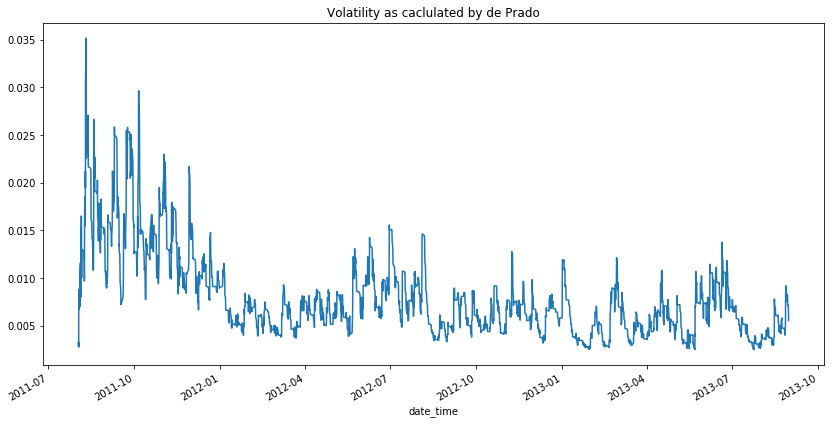

In [6]:
vol.plot(figsize=(14, 7), title='Volatility as caclulated by de Prado')
plt.show()

In [7]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = CoreFunctions.get_t_events(data['close'], threshold=vol.mean())

  1%|          | 104/19998 [00:00<00:19, 1037.71it/s]

Applying Symmetric CUSUM filter.


100%|██████████| 19998/19998 [00:03<00:00, 6349.64it/s]


**Use Snippet 3.4 on a pandas series t1, where numDays=1.**

In [8]:
# Compute vertical barrier
vertical_barriers = CoreFunctions.add_vertical_barrier(cusum_events, data['close'])
vertical_barriers.head()

2011-08-01 13:46:23.650   2011-08-02 13:50:40.053
2011-08-01 14:01:38.747   2011-08-02 14:04:29.869
2011-08-01 15:38:23.090   2011-08-02 15:49:00.114
2011-08-01 19:25:42.891   2011-08-02 19:26:07.927
2011-08-02 07:31:03.237   2011-08-03 08:02:36.120
Name: date_time, dtype: datetime64[ns]

**On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in point 1.b.**

In [9]:
triple_barrier_events = CoreFunctions.get_events(close=data['close'],
                                  t_events=cusum_events,
                                  pt_sl=[1, 1],
                                  target=vol,
                                  min_ret=0.01,
                                  num_threads=1,
                                  vertical_barrier_times=vertical_barriers,
                                  side=None)

/home/ariadne/Desktop/Research Project/research/chapter3/mlfinlab/corefns/core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [10]:
triple_barrier_events.head()

,t1,trgt
2011-08-04 01:57:00.466,2011-08-04 10:27:24.326,0.011060
2011-08-04 09:53:01.844,2011-08-04 13:50:40.606,0.011529
2011-08-04 12:43:40.327,2011-08-04 15:01:19.020,0.010884
2011-08-04 19:30:23.101,2011-08-05 06:36:24.009,0.010586
2011-08-04 19:53:02.682,2011-08-05 12:30:19.803,0.012946


In [11]:
labels = CoreFunctions.get_bins(triple_barrier_events, data['close'])

In [12]:
labels.head()

,ret,trgt,bin
2011-08-04 01:57:00.466,-0.016254,0.011060,-1
2011-08-04 09:53:01.844,-0.012014,0.011529,-1
2011-08-04 12:43:40.327,-0.011109,0.010884,-1
2011-08-04 19:30:23.101,-0.012435,0.010586,-1
2011-08-04 19:53:02.682,0.014829,0.012946,1


In [13]:
labels['bin'].value_counts()

 0    201
 1    175
-1    136
Name: bin, dtype: int64

---
#### 3.2 From exercise 1, use Snippet 3.8 to drop rare labels.

In [14]:
clean_labels = CoreFunctions.drop_labels(labels)

In [15]:
print(labels.shape)
print(clean_labels.shape)

(512, 3)
(512, 3)


---
#### 3.3 Adjust the getBins function (Snippet 3.5) to return a 0 whenever the vertical barrier is the one touched first.
This change was made inside the module CoreFunctions.

---
#### 3.4 Develop a trend-following strategy based on a popular technical analysis statistic (e.g., crossing moving averages). For each observation, themodel suggests a side, but not a size of the bet.

1. Derive meta-labels for pt_sl = [1,2] and t1 where num_days=1. Use as trgt the daily standard deviation as computed by Snippet 3.1.
2. Train a random forest to decide whether to trade or not. Note: The decision is whether to trade or not, {0,1}, since the underllying model (the crossing moveing average has decided the side{-1, 1})

First, Build a simple moving average crossover strateggy

In [16]:
close_prices = data['close']
print(len(close_prices))
close_prices.head()

20000


date_time
2011-07-31 23:31:58.810    1305.75
2011-08-01 02:55:17.443    1306.50
2011-08-01 07:25:56.319    1305.00
2011-08-01 08:33:10.903    1300.00
2011-08-01 10:51:41.842    1307.75
Name: close, dtype: float64

Define the window size for crossover lines

In [17]:
fast_window = 20
slow_window = 50

Create a data frame with the close prices and the rolling moving averages

In [18]:
signal_df = close_prices.to_frame()
signal_df['fast_ma'] = signal_df['close'].rolling(window=fast_window, min_periods=1, center=False).mean()
signal_df['slow_ma'] = signal_df['close'].rolling(window=slow_window, min_periods=1, center=False).mean()
signal_df['side'] = 0.0
signal_df.head()


,close,fast_ma,slow_ma,side
date_time,,,,
2011-07-31 23:31:58.810,1305.75,1305.7500,1305.7500,0.0
2011-08-01 02:55:17.443,1306.50,1306.1250,1306.1250,0.0
2011-08-01 07:25:56.319,1305.00,1305.7500,1305.7500,0.0
2011-08-01 08:33:10.903,1300.00,1304.3125,1304.3125,0.0
2011-08-01 10:51:41.842,1307.75,1305.0000,1305.0000,0.0


Create a side when the short MA crosses over the long MA. Ensure that this is done for the period that is larger than the shortest MA window


In [19]:
# compute sides
signal_df['side'][fast_window:] = np.where(signal_df['fast_ma'][fast_window:] >= 
                                           signal_df['slow_ma'][fast_window:], 1.0, -1.0) 

print(signal_df.side.value_counts())

 1.0    10742
-1.0     9238
 0.0       20
Name: side, dtype: int64


The few 0.0 labels are a result of NaNs

In [20]:
print(signal_df.head())
print(signal_df.tail())

                           close    fast_ma    slow_ma  side
date_time                                                   
2011-07-31 23:31:58.810  1305.75  1305.7500  1305.7500   0.0
2011-08-01 02:55:17.443  1306.50  1306.1250  1306.1250   0.0
2011-08-01 07:25:56.319  1305.00  1305.7500  1305.7500   0.0
2011-08-01 08:33:10.903  1300.00  1304.3125  1304.3125   0.0
2011-08-01 10:51:41.842  1307.75  1305.0000  1305.0000   0.0
                           close    fast_ma   slow_ma  side
date_time                                                  
2013-08-30 19:59:51.155  1630.75  1630.6625  1633.805  -1.0
2013-08-30 19:59:59.085  1629.25  1630.5875  1633.610  -1.0
2013-08-30 20:00:02.187  1631.00  1630.5750  1633.400  -1.0
2013-08-30 20:02:23.500  1632.25  1630.6375  1633.230  -1.0
2013-08-30 20:34:18.899  1631.75  1630.6500  1633.070  -1.0


In [21]:
# extract side as a series
side = signal_df['side']

On those sampled features, apply the triple-barrier method, where ptSl=[1,2] and t1 earlier

In [22]:
ma_events = CoreFunctions.get_events(close_prices,                                     
                                     t_events=cusum_events,
                                     pt_sl=[1, 2],
                                     target=vol,
                                     min_ret=0.01,
                                     num_threads=1,
                                     vertical_barrier_times=vertical_barriers,
                                     side=side)


In [23]:
print(ma_events.head())
print('')
print(ma_events.side.value_counts())

                         side                      t1      trgt
2011-08-04 01:57:00.466   1.0 2011-08-04 14:12:16.878  0.011060
2011-08-04 09:53:01.844   1.0 2011-08-04 15:43:40.842  0.011529
2011-08-04 12:43:40.327   1.0 2011-08-04 18:27:50.147  0.010884
2011-08-04 19:30:23.101  -1.0 2011-08-05 06:36:24.009  0.010586
2011-08-04 19:53:02.682  -1.0 2011-08-05 15:16:11.831  0.012946

 1.0    257
-1.0    255
Name: side, dtype: int64


In [24]:
labels = CoreFunctions.get_bins(ma_events, close_prices)

In [25]:
print(labels.head())
labels.bin.value_counts()

                              ret      trgt  bin
2011-08-04 01:57:00.466 -0.022597  0.011060    0
2011-08-04 09:53:01.844 -0.023228  0.011529    0
2011-08-04 12:43:40.327 -0.022824  0.010884    0
2011-08-04 19:30:23.101  0.012435  0.010586    1
2011-08-04 19:53:02.682  0.014620  0.012946    1


0    334
1    178
Name: bin, dtype: int64

(3.4b) Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1) 

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

In [27]:
# compute auto-correlation
auto_corr = CoreFunctions.get_autocorr(close_prices)

Calculating Daily AutoCorr


In [28]:
len(auto_corr)

19945

In [29]:
# compute fractionally differentiated prices
from statsmodels.tsa.stattools import adfuller

fracs = frac_diff_ffd(close_prices.apply(np.log), differencing_amt=0.39, threshold=1e-5)
result = adfuller(fracs, maxlag=2, regression='C', autolag='AIC', store=False, regresults=False)
print('ADF Statistic: %f' % abs(round(result[0], 3)))
print('p-value: %f' % result[1])
print('Critical values:')
for k, v in result[4].items():
    print('\t%s: %.3f' % (k, v))

frac_df = pd.Series(index=close_prices.index, data=fracs).rename('fracdiff')
frac_df.tail()

ADF Statistic: 3.516000
p-value: 0.007574
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


date_time
2013-08-30 19:59:51.155    0.288143
2013-08-30 19:59:59.085    0.287063
2013-08-30 20:00:02.187    0.288437
2013-08-30 20:02:23.500    0.288869
2013-08-30 20:34:18.899    0.288184
Name: fracdiff, dtype: float64

In [30]:
ma_events.shape

(512, 3)

In [31]:
labels.shape

(512, 3)

In [32]:
auto_corr.shape

(19945,)

In [33]:
# Create feature matrix
X = pd.DataFrame(labels['trgt'])
X['side'] = [ma_events['side'][x] for x in X.index]
X['autocorr'] = [auto_corr[x] for x in X.index]
X['fast_ma'] = [signal_df['fast_ma'][x] for x in X.index]
X['slow_ma'] = [signal_df['slow_ma'][x] for x in X.index]
X['fracdiff'] = [frac_df[x] for x in X.index]
print(X.tail())

                             trgt  side  autocorr    fast_ma   slow_ma  \
2013-06-21 07:09:37.942  0.011954  -1.0  0.975765  1583.0875  1590.175   
2013-06-21 14:31:34.774  0.011097   1.0  0.968678  1589.8500  1587.230   
2013-06-24 03:22:10.088  0.010504   1.0  0.981188  1584.6750  1581.755   
2013-06-25 19:33:49.301  0.011368   1.0  0.979041  1579.4250  1576.015   
2013-06-26 12:26:25.424  0.010686   1.0  0.980111  1582.3500  1578.950   

                         fracdiff  
2013-06-21 07:09:37.942  0.290053  
2013-06-21 14:31:34.774  0.283423  
2013-06-24 03:22:10.088  0.281016  
2013-06-25 19:33:49.301  0.289833  
2013-06-26 12:26:25.424  0.291114  


In [34]:
# extract y values
y = labels.bin.to_frame()

In [35]:
print(X.shape)
print(y.shape)

(512, 6)
(512, 1)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [37]:
print(X_train.shape)
print(y_train.shape)

(409, 6)
(409, 1)


In [38]:
n_estimator = 10000
c_random_state = 42

rf = RandomForestClassifier(max_depth=5, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Performance: Training

              precision    recall  f1-score   support

           0       0.74      0.98      0.84       252
           1       0.92      0.46      0.61       157

   micro avg       0.78      0.78      0.78       409
   macro avg       0.83      0.72      0.73       409
weighted avg       0.81      0.78      0.76       409

Confusion Matrix
[[246   6]
 [ 85  72]]


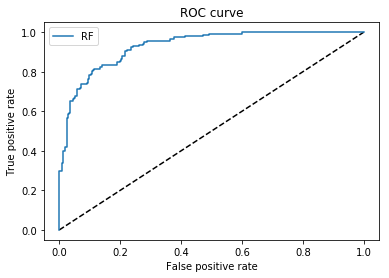

In [39]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Performance: Test

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        82
           1       0.40      0.10      0.15        21

   micro avg       0.79      0.79      0.79       103
   macro avg       0.60      0.53      0.52       103
weighted avg       0.72      0.79      0.73       103

Confusion Matrix
[[79  3]
 [19  2]]


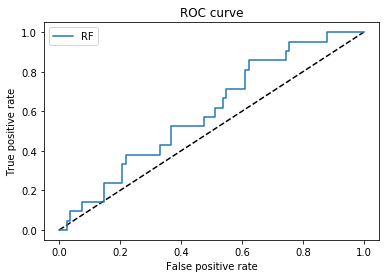

In [40]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

---
### Bollinger Band Mean Reverting Strategy

In [41]:
def bbands(close_prices, window, no_of_stdev):
    rolling_mean = close_prices.rolling(window=window).mean()
    rolling_std = close_prices.rolling(window=window).std()
    # rolling_mean = close_prices.ewm(span=window).mean()
    # rolling_std = close_prices.ewm(span=window).std()
    
    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)
    
    return rolling_mean, upper_band, lower_band


In [42]:
window = 50
rolling_mean, upper_band, lower_band = bbands(close_prices, window, no_of_stdev=2)

In [43]:
print(rolling_mean.tail())
print(upper_band.tail())
print(lower_band.tail())

date_time
2013-08-30 19:59:51.155    1633.805
2013-08-30 19:59:59.085    1633.610
2013-08-30 20:00:02.187    1633.400
2013-08-30 20:02:23.500    1633.230
2013-08-30 20:34:18.899    1633.070
Name: close, dtype: float64
date_time
2013-08-30 19:59:51.155    1641.771313
2013-08-30 19:59:59.085    1641.534491
2013-08-30 20:00:02.187    1641.021800
2013-08-30 20:02:23.500    1640.556107
2013-08-30 20:34:18.899    1640.160551
Name: close, dtype: float64
date_time
2013-08-30 19:59:51.155    1625.838687
2013-08-30 19:59:59.085    1625.685509
2013-08-30 20:00:02.187    1625.778200
2013-08-30 20:02:23.500    1625.903893
2013-08-30 20:34:18.899    1625.979449
Name: close, dtype: float64


In [44]:
# source: https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
    # df = df.join(RSI)
    return RSI


In [45]:
data.tail()
data_df = data.copy(deep=True).reset_index()
rsi_df = relative_strength_index(data_df, 14)
rsi_df.tail()

19995    50.0
19996    44.0
19997    42.0
19998    48.0
19999    56.0
Name: RSI_14, dtype: float64

In [90]:
# create the data frame
signal_df = close_prices.to_frame()
signal_df['avg'] = rolling_mean
signal_df['upper'] = upper_band
signal_df['lower'] = lower_band
signal_df['rsi'] = pd.Series(data=rsi_df.values, index=signal_df.index)
signal_df['side'] = 0.0

signal_df.tail()

,close,avg,upper,lower,rsi,side
date_time,,,,,,
2013-08-30 19:59:51.155,1630.75,1633.805,1641.771313,1625.838687,50.0,0.0
2013-08-30 19:59:59.085,1629.25,1633.610,1641.534491,1625.685509,44.0,0.0
2013-08-30 20:00:02.187,1631.00,1633.400,1641.021800,1625.778200,42.0,0.0
2013-08-30 20:02:23.500,1632.25,1633.230,1640.556107,1625.903893,48.0,0.0
2013-08-30 20:34:18.899,1631.75,1633.070,1640.160551,1625.979449,56.0,0.0


In [91]:
# Apply Bolinger band strategy
"""
The following is a mean reverting strategy using Bollinger Bands:
* If price above upper band then short.
* If price below bottom band then long.
* If price cross mean price then close all positions.
"""
current_side = 0

store = []
for row in signal_df.itertuples():
        # Buy signal
        if row.close > row.upper and current_side != -1:
            current_side = -1
            store.append(current_side)
            
        # Short signal
        elif row.close < row.lower and current_side != 1:
            current_side = 1
            store.append(current_side)
        
        # Close signal long
        elif current_side == 1 and row.close > row.avg:
            current_side = 0
            store.append(current_side)
            
        # Close signal short
        elif current_side == -1 and row.close < row.avg:
            current_side = 0
            store.append(current_side)
            
        # No action
        else:
            store.append(current_side)
            
signal_df['side'] = store

In [93]:
signal_df['side'].value_counts()

 0    8061
-1    6515
 1    5424
Name: side, dtype: int64

In [94]:
# extract side as a series 
side = signal_df['side']
bb_events = CoreFunctions.get_events(close_prices,                                     
                                     t_events=cusum_events,
                                     pt_sl=[0, 2],
                                     target=vol,
                                     min_ret=0.01,
                                     num_threads=1,
                                     vertical_barrier_times=vertical_barriers,
                                     side=side)


/home/ariadne/Desktop/Research Project/research/chapter3/mlfinlab/corefns/core_functions.py:205: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]


In [95]:
bb_events.tail()
bb_events.side.value_counts()

 0.0    198
-1.0    159
 1.0    155
Name: side, dtype: int64

In [96]:
labels = CoreFunctions.get_bins(bb_events, close_prices)

In [97]:
print(labels.head())
labels.bin.value_counts()

                              ret      trgt  bin
2011-08-04 01:57:00.466  0.049554  0.011060    1
2011-08-04 09:53:01.844  0.042451  0.011529    1
2011-08-04 12:43:40.327 -0.000000  0.010884    0
2011-08-04 19:30:23.101 -0.022176  0.010586    0
2011-08-04 19:53:02.682 -0.027360  0.012946    0


0    454
1     58
Name: bin, dtype: int64

In [98]:
frac_df.tail()

date_time
2013-08-30 19:59:51.155    0.288143
2013-08-30 19:59:59.085    0.287063
2013-08-30 20:00:02.187    0.288437
2013-08-30 20:02:23.500    0.288869
2013-08-30 20:34:18.899    0.288184
Name: fracdiff, dtype: float64

In [105]:
# Create feature matrix
X = pd.DataFrame(labels['trgt'])
X['side'] = [bb_events['side'][x] for x in X.index]
X['autocorr'] = [auto_corr[x] for x in X.index]
X['fracdiff'] = [frac_df[x] for x in X.index]
print(X.tail())

                             trgt  side  autocorr  fracdiff
2013-06-21 07:09:37.942  0.011954   0.0  0.975765  0.290053
2013-06-21 14:31:34.774  0.011097   0.0  0.968678  0.283423
2013-06-24 03:22:10.088  0.010504   0.0  0.981188  0.281016
2013-06-25 19:33:49.301  0.011368  -1.0  0.979041  0.289833
2013-06-26 12:26:25.424  0.010686  -1.0  0.980111  0.291114


In [106]:
# extract y values
y = labels.bin.to_frame()

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [114]:
n_estimator = 10000
c_random_state = 42

rf = RandomForestClassifier(max_depth=5, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Performance: Training

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       363
           1       0.95      0.43      0.60        46

   micro avg       0.93      0.93      0.93       409
   macro avg       0.94      0.72      0.78       409
weighted avg       0.94      0.93      0.92       409

Confusion Matrix
[[362   1]
 [ 26  20]]


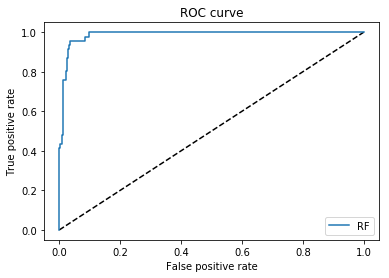

In [115]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Performance: Test

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        91
           1       0.00      0.00      0.00        12

   micro avg       0.88      0.88      0.88       103
   macro avg       0.44      0.50      0.47       103
weighted avg       0.78      0.88      0.83       103

Confusion Matrix
[[91  0]
 [12  0]]


/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


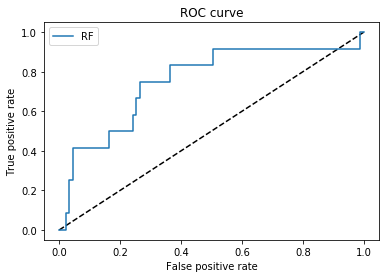

In [116]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()